# Pipetography

> Nipype and mrtrix3 based pre-/post- processing pipeline for brain diffusion-MRI and generation of structural connectomes of the brain.

![CI](https://github.com/axiezai/pipetography/workflows/CI/badge.svg)
![docker](https://img.shields.io/docker/v/axiezai/pipetography)

This repo currently only has pre-processing capabilities! More will be added in the near future.

## Install

Install version `0.1.0`:

`pip install pipetography`

Since `pipetography` is a `Nipype` wrapper around `mrtrix3`, `ANTs`, and `FSL`, you have to follow their installation instructions and set them up appropriately on your machine as well:    
 - [mrtrix3](https://mrtrix.readthedocs.io/en/latest/installation/before_install.html)
 
 - [ANTs](https://github.com/ANTsX/ANTs/wiki/Compiling-ANTs-on-Linux-and-Mac-OS)
     
 - [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslInstallation)

## How to use

#### Use as connected Nipype nodes for DWI preprocessing
We will wrap all of our tasks in `Nipype`'s `Nodes`

Nipype wraps the tasks into Nodes and connects them into an automated workflow that can run parallel tasks, the preprocessing workflow includes several functions, some of which require user inputs. We will go over them here.

In [ ]:
%%capture
from pipetography.pipeline import pipeline
from pipetography.core import *

preproc_dwi = pipeline()

In [ ]:
#example
preproc_dwi.check_environment()

FSLOUTPUTTYPE is valid
FSLDIR is valid
ANTS is valid
mrtrix3 is valid


In [ ]:
#example
#set output destination:
preproc_dwi.set_datasink()

Please indicate an output directory:  'output'


Take a look at what's in the `pipeline`:

In [ ]:
#example
preproc_dwi.__dict__

{'data_dir': 'data',
 'sub_list': ['11048'],
 'layout': BIDS Layout: ...ers/xxie/lab/pipetography/data | Subjects: 1 | Sessions: 1 | Runs: 0,
 'dwi_file': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.nii.gz',
 'b_files': 'sub-{subject_id}/ses-1/dwi/sub-{subject_id}_ses-1_dwi.bv*',
 'sub_template': {'dwi': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.nii.gz',
  'b_files': 'sub-{subject_id}/ses-1/dwi/sub-{subject_id}_ses-1_dwi.bv*'},
 'sub_source': data_source,
 'select_files': select_files,
 'bfiles_input': select_bfiles,
 'denoise': denoise,
 'ringing': ringing_removal,
 'ants_bfc': ants_bias_correct,
 'mrt_preproc': mrtrix3_preproc,
 'atlas_dir': None,
 'atlas_names': None,
 'atlas_source': None,
 'select_atlas': None,
 'b0extract': dwiextract,
 'b0mean': mrmath,
 'fsl_bet': brain_extraction,
 'linear_coreg': linear_registration,
 'nonlinear_coreg': nonlinear_registration,
 'datasink': datasink,
 'workflow': None}

We can set up preprocessing pipeline with default parameters:

In [ ]:
#example
preproc_dwi.default_setup()

Please indicate directory with atlas volumes:  '/Users/xxie/lab/atlases'
Please indicate list of selected atlas names:  ['BN_Atlas_246_2mm.nii','DK_atlas86_1mm.nii']


{'data_dir': 'data', 'sub_list': ['11048'], 'layout': BIDS Layout: ...ers/xxie/lab/pipetography/data | Subjects: 1 | Sessions: 1 | Runs: 0, 'dwi_file': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.nii.gz', 'b_files': 'sub-{subject_id}/ses-1/dwi/sub-{subject_id}_ses-1_dwi.bv*', 'sub_template': {'dwi': 'sub-{subject_id}/ses-*/dwi/sub-{subject_id}_ses-*_dwi.nii.gz', 'b_files': 'sub-{subject_id}/ses-1/dwi/sub-{subject_id}_ses-1_dwi.bv*'}, 'sub_source': default_workflow.data_source, 'select_files': default_workflow.select_files, 'bfiles_input': default_workflow.select_bfiles, 'denoise': default_workflow.denoise, 'ringing': default_workflow.ringing_removal, 'ants_bfc': default_workflow.ants_bias_correct, 'mrt_preproc': default_workflow.mrtrix3_preproc, 'atlas_dir': "'/Users/xxie/lab/atlases'", 'atlas_names': ['[', "'", 'B', 'N', '_', 'A', 't', 'l', 'a', 's', '_', '2', '4', '6', '_', '2', 'm', 'm', '.', 'n', 'i', 'i', "'", ',', "'", 'D', 'K', '_', 'a', 't', 'l', 'a', 's', '8', '6', 

Then you can simply call `preproc_dwi.draw_pipeline()` to visualize the workflow as a PNG image, or `preproc_dwi.run_pipeline()` to run the default pipeline. OR we can fill this in one by one in detail:

First, let's tell the pipeline where we have atlas volumes and which ones to use:

In [ ]:
#example
preproc_dwi.atlas_inputs(atlas_dir = '/Users/xxie/lab/atlases', atlas_names = ['BN_Atlas_246_2mm.nii','DK_atlas86_1mm.nii'])

Next, we give inputs to the `denoise` Node:

In [ ]:
#example
preproc_dwi.denoise_inputs(force = True, quiet = True)
# we kept everything else default, like output names and number of threads.

Gibbs ringing removal:

In [ ]:
#example
preproc_dwi.DeGibbs_inputs() # keep it default
print('Output file name is ' + preproc_dwi.ringing.inputs.out_file)

Output file name is ringing_removed.nii.gz


ANTs Bias Field Correction:

In [ ]:
#example
preproc_dwi.ants_bfc_inputs() # keep it default:
preproc_dwi.ants_bfc.inputs.print_traits

<bound method HasTraits.print_traits of 
args = <undefined>
dims = 4
environ = {}
in_file = <undefined>
out_file = biasfieldcorrected.nii.gz
>

`in_file` is undefined because we will feed it this information once we connect our individual functions.

Next let's set up eddy current/motion correction, we need to tell the pipeline the phase encoding settings and inputs to eddy algorithm:

In [ ]:
#example
preproc_dwi.mrt_preproc_inputs(
    rpe_options="-rpe_none",
    pe_dir="j-",
    eddy_options='"--slm=linear --verbose"',
    nthreads=4,
)
preproc_dwi.mrt_preproc.inputs.print_traits

<bound method HasTraits.print_traits of 
args = <undefined>
eddy_options = "--slm=linear --verbose"
environ = {}
grad_fsl = <undefined>
in_file = <undefined>
nthreads = 4
out_file = preproc.nii.gz
pe_dir = j-
rpe_options = -rpe_none
>

`grad_fsl` and `in_file` will be input via connected workflow later

Next, we set-up brain extraction from B0 volumes:

In [ ]:
#example
# Extract b0 volumes:
preproc_dwi.b0extract_inputs() #default
# Create average B0 volume:
preproc_dwi.b0mean_inputs() #default
# Extract brain from B0 average volume:
preproc_dwi.bet_inputs() #defaults again, using FSL's BET

ANTs registration set up:

In [ ]:
#example
preproc_dwi.linear_coreg_inputs() #defaults
preproc_dwi.nonlinear_coreg_inputs() #defaults
preproc_dwi.nonlinear_coreg.inputs.print_traits

<bound method HasTraits.print_traits of 
args = <undefined>
collapse_output_transforms = True
convergence_threshold = [1e-06]
convergence_window_size = [10]
dimension = 3
environ = {'NSLOTS': '1'}
fixed_image = <undefined>
fixed_image_mask = <undefined>
fixed_image_masks = <undefined>
float = <undefined>
initial_moving_transform = <undefined>
initial_moving_transform_com = <undefined>
initialize_transforms_per_stage = False
interpolation = Linear
interpolation_parameters = <undefined>
invert_initial_moving_transform = <undefined>
metric = ['MI']
metric_item_trait = <undefined>
metric_stage_trait = <undefined>
metric_weight = [1.0]
metric_weight_item_trait = 1.0
metric_weight_stage_trait = <undefined>
moving_image = <undefined>
moving_image_mask = <undefined>
moving_image_masks = <undefined>
num_threads = 1
number_of_iterations = [[500, 200, 200, 100]]
output_inverse_warped_image = <undefined>
output_transform_prefix = atlas_in_dwi_syn
output_warped_image = atlas_in_dwi_syn.nii.gz
radiu

All the default settings may not be optimal for your dataset, run the processing for a test image and see the intermediate results and then tweak the available inputs to improve the output image quality.

Now that our pre-processing Nodes are properly setup, we can connect and create a workflow:

In [ ]:
#example
preproc_dwi.connect_nodes(wf_name = 'pipetography_workflow')
preproc_dwi.draw_pipeline()

Let's take a look at the final workflow we created:

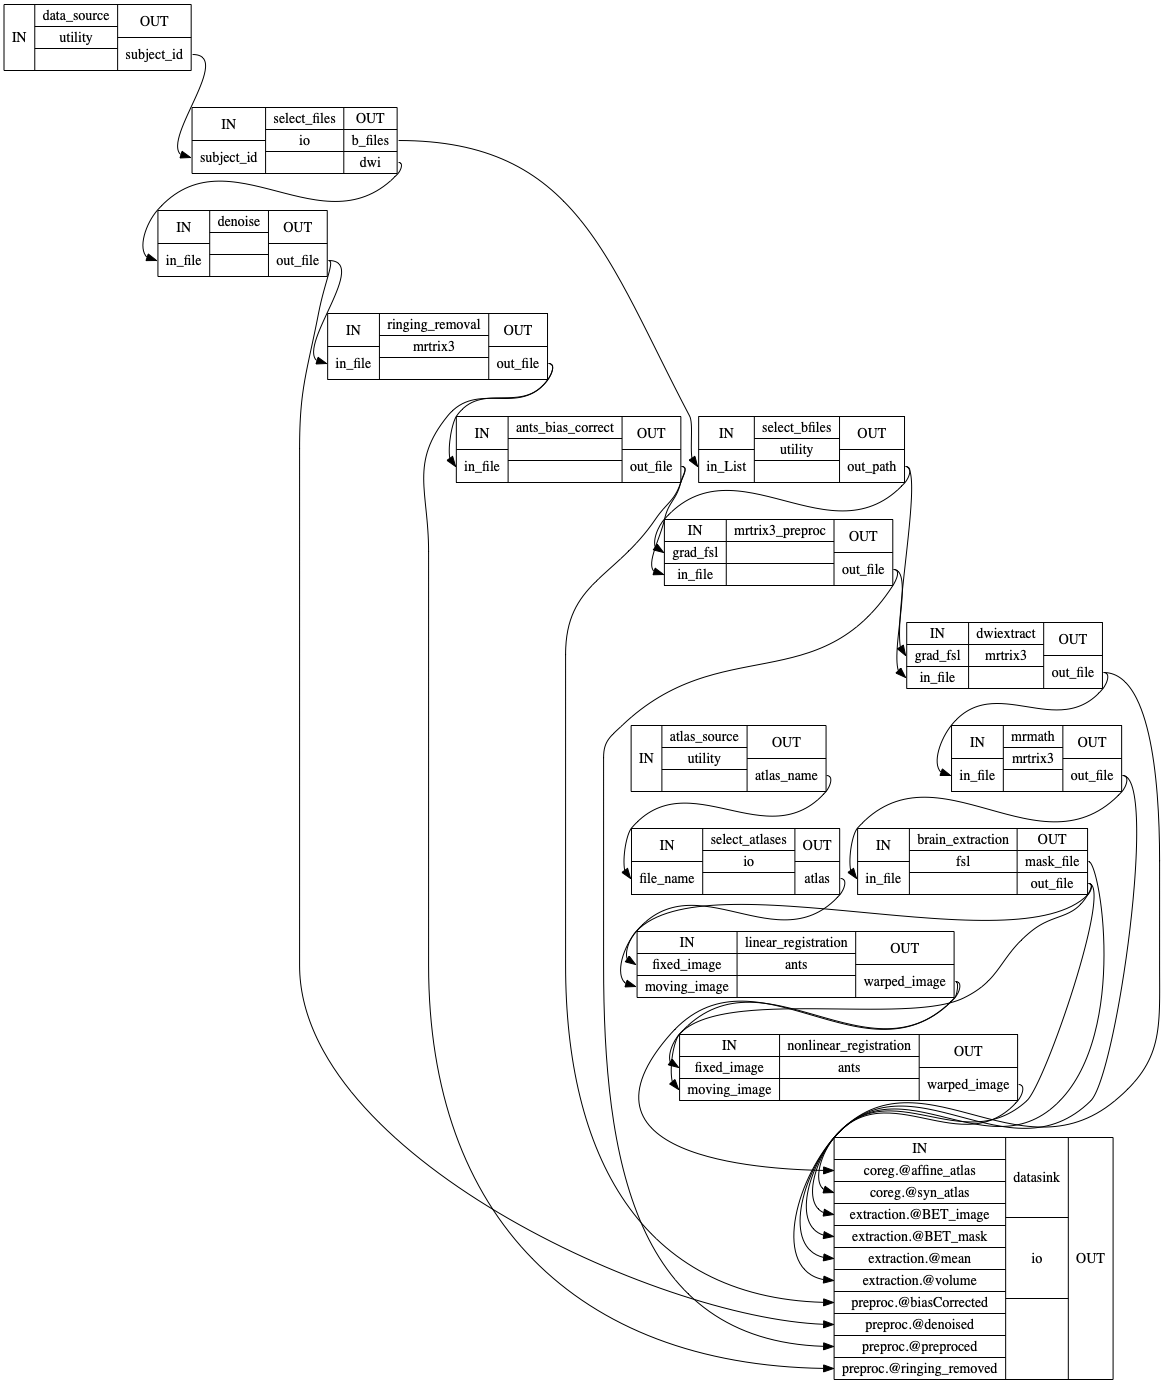

In [ ]:
#example
from IPython.display import Image
Image('data/derivatives/test_run/pipetography_detailed.png')

Finally, to run the entire pipeline with our inputs. When we declare `parallel = True`, we are telling Nipype to run parallel pipelines for each iterable input, the pipeline will prompt an input for the number of processes. If you enter `4`, there will be 4 processes taking up your available computing resources:

In [ ]:
#example
preproc_dwi.run_pipeline(parallel = True)